In [1]:
import helpers as h
import sub_gradient
import qlearning_astar
import numpy as np
import geopandas as gpd
import pickle

c:\Users\krishn001\AppData\Local\anaconda3\envs\rl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adj_matrix_path = "preprocessed_data/adjacency_matrix_osdpm.txt"
gdf_path = "preprocessed_data/gdf_osdpm_connected.gpkg"
node_dict_path = "preprocessed_data/node_dict_osdpm.pickle"

In [3]:
graph = h.load_adjacency_matrix_safe(adj_matrix_path)
gdf_osdpm_connected_pt = gpd.read_file(gdf_path)

with open(node_dict_path, 'rb') as f:
        node_dict = pickle.load(f)

In [4]:
### source and target

origin_lat = 52.350790
origin_lon = 4.798740
destination_lat = 52.363189
destination_lon = 4.792537

source, distance = h.find_nearest_node(origin_lat, origin_lon, node_dict)
target, distance = h.find_nearest_node(destination_lat, destination_lon, node_dict)

### sub-gradient algorithm

In [5]:


constraints = [100000, 100000, 100000, 100000] # arbitrary constraints

weights = [1,5,1,1] #increase to minimize value

routes = sub_gradient.subgradient_multiple_routes(graph, source, target, constraints, weights, max_iter=100, tol=1e-3)

<Axes: >

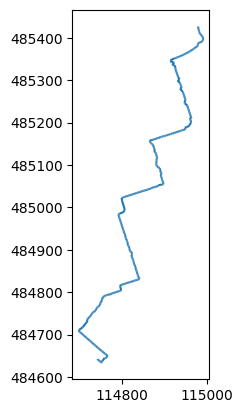

In [6]:
# path list to gdf and visualisation

h.get_route_gdf(routes[0][1], gdf_osdpm_connected_pt).plot()

#### Q-learning a star

In [7]:
G = h.convert_to_multidigraph(gdf_osdpm_connected_pt)

In [ ]:
weights = {'length': -1, 'crossing': -2, 'bike': 5, 'walk': 3}

# initialize Q-Learning A* class
ql_learner = qlearning_astar.QLearningHeuristicAStar(G, weights, maximize_bike=True)
ql_learner.simulate_random_walks(source, target, num_steps=1)

# path determined using Q-learning-enhanced A*
route = ql_learner.a_star(source, target)

<Axes: >

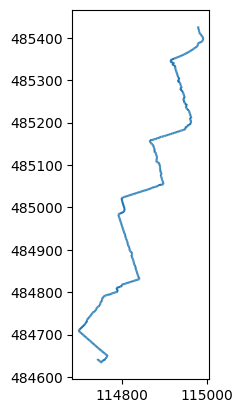

In [9]:
# path list to gdf and visualisation

h.get_route_gdf(route['path'], gdf_osdpm_connected_pt).plot()